In [1]:
import pandas as pd
from google.colab import auth
import gspread
from google.auth import default

# Authenticate
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open spreadsheet (using your URL)
spreadsheet_url = 'https://docs.google.com/spreadsheets/d/1IWa_g1cV54JcTRdXXUCFElOAvQcfy0o5wDI34IpdnYs/edit?usp=sharing'
worksheet = gc.open_by_url(spreadsheet_url).sheet1
data = worksheet.get_all_records()
df = pd.DataFrame(data)

# Now you can view your data
print(df.shape)  # See the dimensions of your dataframe
df.head()  # View first few rows

(212, 48)


,,Sector,Last page,Have you smoked at least one full tobacco cigarette (excluding e-cigarettes) once or more in the past 30 days?,"I see myself as someone who is extraverted, enthusiastic:","I see myself as someone who is critical, quarrelsome:","I see myself as someone who is dependable, self-disciplined:","I see myself as someone who is anxious, easily upset:",I see myself as someone who is open to new experiences:,"I see myself as someone who is reserved, quiet:",...,What type of income or financial support does your household receive?,What type of income or financial support does your household receive? [Comment],"If you receive payment in Lebanese Lira, what is your current estimated monthly household income? (If income is in US Dollars, then refer to the current black market exchange).",How would you describe your current income sufficiency?,"Including yourself, how many people currently live in your household?",To what extent were you financially (negatively) affected by the deterioration of the Lebanese economy?,How often do you exercise?,"On average, how many hours per day do you spend on social media for entertainment and social interaction (Facebook, Instagram, YouTube, etc...)?",How often do you feel stressed?,Employment Status
0,5,Private,5,Yes,Agree strongly,Disagree moderately,Agree strongly,Agree moderately,Agree strongly,Agree a little,...,Fully in Lebanese Lira,,More than 20 million L.L,High: completely covers necessities with a few...,4,Very,Never,Between 2 and 3 hours,Frequently,Employed
1,11,Private,5,Yes,Agree moderately,Agree moderately,Agree moderately,Agree a little,Agree strongly,Disagree strongly,...,Fully in US Dollars,,More than 20 million L.L,High: completely covers necessities with a few...,4,Slightly,Often or at least 3 days every week,Between 2 and 3 hours,Occasionally,Unemployed
2,14,Private,5,Yes,Disagree moderately,Neither agree nor disagree,Agree a little,Agree moderately,Disagree a little,Agree moderately,...,Fully in Lebanese Lira,,I don't know,High: completely covers necessities with a few...,4,Moderately,Every day or at least 5 times every week,More than 4 hours,Constantly,Employed
3,15,Private,5,Yes,Agree strongly,Disagree moderately,Agree strongly,Disagree strongly,Agree strongly,Disagree moderately,...,Mixed,,I don't know,Medium: covers all basic needs,5,Moderately,Often or at least 3 days every week,Between 2 and 3 hours,Occasionally,Employed
4,16,Private,5,Yes,Agree a little,Agree a little,Agree strongly,Disagree moderately,Agree moderately,Agree strongly,...,"Other, please specify",,I prefer not to say,Medium: covers all basic needs,6,Slightly,Every day or at least 5 times every week,Less than 1 hour,Never,Employed


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [5]:
# Load your dataset
# Replace 'data.csv' with your actual file path
data = df

# Example preprocessing steps
# One-hot encoding, feature scaling, and target encoding
def preprocess_data(df):
    # Handle binary columns
    binary_columns = [col for col in df.columns if set(df[col].dropna().unique()) == {"Yes", "No"}]
    for col in binary_columns:
        df[col] = df[col].map({"Yes": 1, "No": 0})

    # Encode personality responses (example mapping)
    response_map = {
        "Disagree strongly": 0, "Disagree moderately": 1, "Disagree a little": 2,
        "Neither agree nor disagree": 3, "Agree a little": 4,
        "Agree moderately": 5, "Agree strongly": 6
    }
    personality_columns = [col for col in df.columns if "I see myself as" in col]
    for col in personality_columns:
        df[col] = df[col].map(response_map)

    # Target encoding
    target_map = {
        "10 or less cigarettes/day": 0,
        "11 to 20 cigarettes": 1,
        "21 to 30 cigarettes": 2,
        "31 cigarettes/day or more": 3
    }
    df["smoking_intensity"] = df["How many cigarettes do you smoke each day?"].map(target_map)
    df = df.drop(columns=["How many cigarettes do you smoke each day?"], errors="ignore")

    # One-hot encoding for categorical columns
    df_encoded = pd.get_dummies(df, drop_first=True)

    # Separate features and target
    X = df_encoded.drop(columns=['smoking_intensity'], errors='ignore')
    y = df_encoded['smoking_intensity']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return pd.DataFrame(X_scaled, columns=X.columns), y

X, y = preprocess_data(data)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [8]:
# Drop rows with missing values
X_train_dropped = X_train.dropna()
X_test_dropped = X_test.dropna()


In [9]:
# Apply K-Means clustering after imputing missing values
kmeans = KMeans(n_clusters=3, random_state=42)
X_train['cluster'] = kmeans.fit_predict(X_train_imputed)
X_test['cluster'] = kmeans.predict(X_test_imputed)


In [10]:
print("Number of missing values in training data:", np.isnan(X_train_imputed).sum())
print("Number of missing values in test data:", np.isnan(X_test_imputed).sum())


Number of missing values in training data: 0
Number of missing values in test data: 0


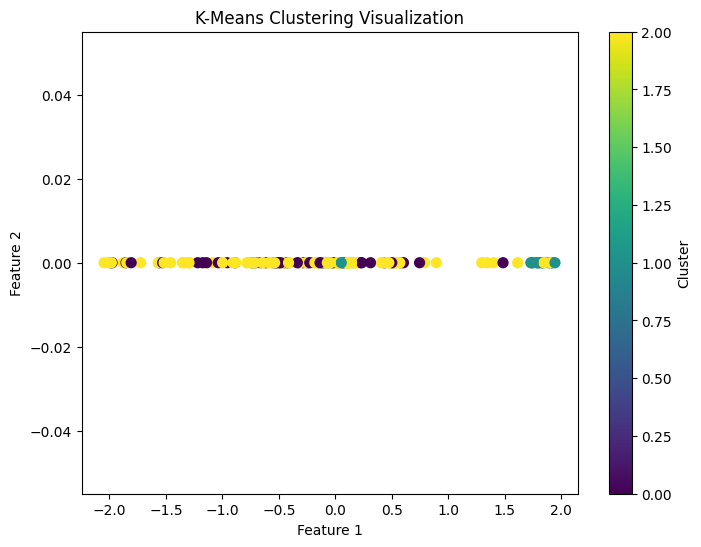

In [11]:
# Visualize clusters using the first two features (scaled)
plt.figure(figsize=(8, 6))
plt.scatter(
    X_train_imputed[:, 0],  # First feature
    X_train_imputed[:, 1],  # Second feature
    c=kmeans.labels_,       # Cluster assignments
    cmap='viridis',
    s=50
)
plt.title("K-Means Clustering Visualization")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Cluster")
plt.show()


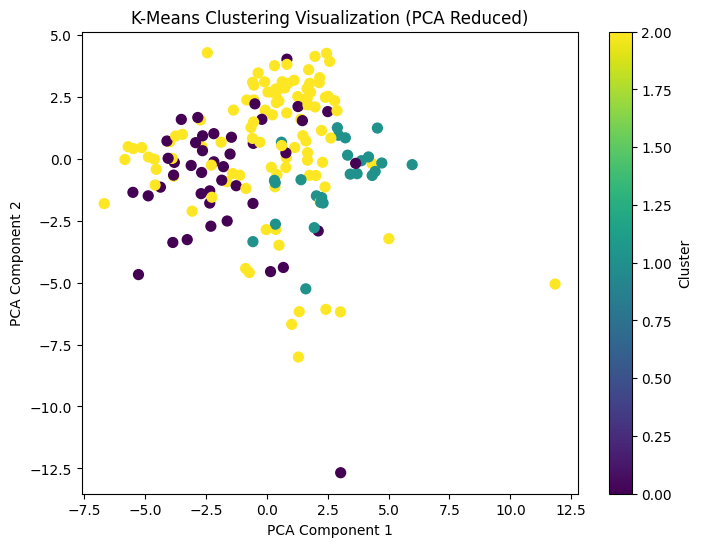

In [14]:
from sklearn.decomposition import PCA

# Reduce data to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_imputed)

# Plot clusters in PCA-reduced space
plt.figure(figsize=(8, 6))
plt.scatter(
    X_train_pca[:, 0],  # PCA Component 1
    X_train_pca[:, 1],  # PCA Component 2
    c=kmeans.labels_,   # Cluster assignments
    cmap='viridis',
    s=50
)
plt.title("K-Means Clustering Visualization (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


In [22]:
# Apply SVD for 2D reduction
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd_2d = svd.fit_transform(X_train_imputed)

# Apply SVD for 3D reduction (optional for 3D visualization)
svd_3d = TruncatedSVD(n_components=3, random_state=42)
X_svd_3d = svd_3d.fit_transform(X_train_imputed)


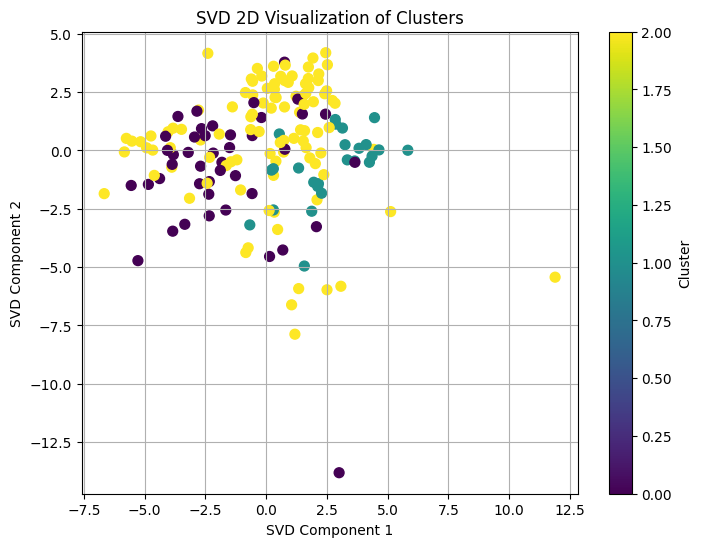

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(
    X_svd_2d[:, 0],  # First principal component
    X_svd_2d[:, 1],  # Second principal component
    c=kmeans.labels_,  # Cluster labels
    cmap='viridis',
    s=50
)
plt.title("SVD 2D Visualization of Clusters")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()


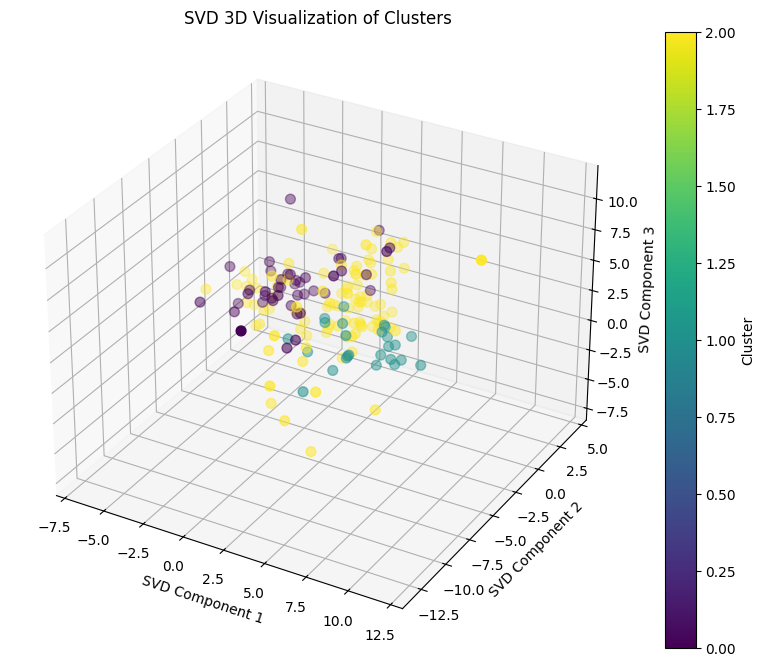

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    X_svd_3d[:, 0],  # First principal component
    X_svd_3d[:, 1],  # Second principal component
    X_svd_3d[:, 2],  # Third principal component
    c=kmeans.labels_,  # Cluster labels
    cmap='viridis',
    s=50
)
ax.set_title("SVD 3D Visualization of Clusters")
ax.set_xlabel("SVD Component 1")
ax.set_ylabel("SVD Component 2")
ax.set_zlabel("SVD Component 3")
plt.colorbar(scatter, label="Cluster")
plt.show()


In [25]:
# Explained variance ratio
explained_variance = svd.explained_variance_ratio_
print("Explained Variance Ratio (2D):", explained_variance)
print("Total Explained Variance (2D):", explained_variance.sum())

explained_variance_3d = svd_3d.explained_variance_ratio_
print("Explained Variance Ratio (3D):", explained_variance_3d)
print("Total Explained Variance (3D):", explained_variance_3d.sum())


Explained Variance Ratio (2D): [0.02712387 0.02319353]
Total Explained Variance (2D): 0.050317404994082895
Explained Variance Ratio (3D): [0.02712457 0.02316854 0.02201195]
Total Explained Variance (3D): 0.0723050543752414


<Figure size 1000x600 with 0 Axes>

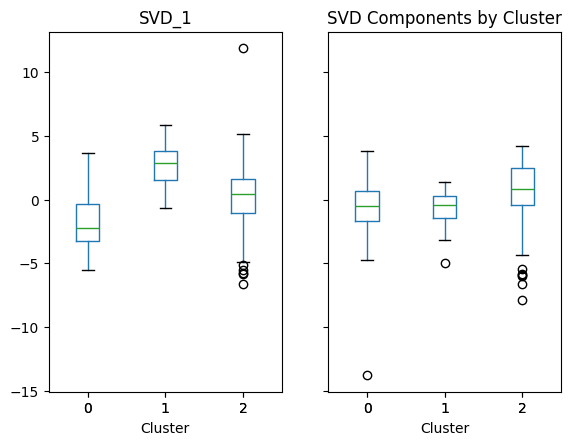

In [26]:
# Create a DataFrame to link SVD components with clusters
svd_df = pd.DataFrame(X_svd_2d, columns=['SVD_1', 'SVD_2'])
svd_df['Cluster'] = kmeans.labels_

# Boxplot of SVD components by cluster
plt.figure(figsize=(10, 6))
svd_df.boxplot(by='Cluster', column=['SVD_1', 'SVD_2'], grid=False)
plt.suptitle("")
plt.title("SVD Components by Cluster")
plt.show()


In [28]:
# Adjust column names to match the shape of the components
aligned_columns = X_train.columns[:svd.components_.shape[1]]

# Create a DataFrame for feature contributions
feature_contributions = pd.DataFrame(
    svd.components_.T, index=aligned_columns, columns=['SVD_1', 'SVD_2']
)

# Top features for the first SVD component
print("Top features contributing to SVD Component 1:")
print(feature_contributions['SVD_1'].sort_values(ascending=False).head(10))

# Top features for the second SVD component
print("\nTop features contributing to SVD Component 2:")
print(feature_contributions['SVD_2'].sort_values(ascending=False).head(10))



Top features contributing to SVD Component 1:
How often do you exercise?_Sometimes or a few days every month                                                                                                                                              0.223438
What is the highest level of education you have attained?_Graduate degree (MA/MS)                                                                                                                           0.209261
What cigarette brand(s) are you currently using?_marlboro or iqos                                                                                                                                           0.180372
What is your current marital status? [Comment]_Planning to get engaged                                                                                                                                      0.164037
I see myself as someone who is extraverted, enthusiastic:                                             